In [3]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [4]:
# Load dataset
df = pd.read_csv('../data/preprocessed-data.csv')
df.fillna(df.mean(), inplace=True)

# Split features and target
X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train+val into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 60/20/20 split

test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv('../data/test-data.csv', index=False)

# Initialize and train the model
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)

# Predict again
y_val_pred = dt_model.predict(X_val)
y_test_pred = dt_model.predict(X_test)



In [5]:
df.isna().sum().sum()

np.int64(0)

In [6]:
# Initial model evaluation

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Validation Set Metrics:
Accuracy: 0.8578651935670691
ROC-AUC: 0.5342910875284552

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     41241
           1       0.14      0.15      0.14      3653

    accuracy                           0.86     44894
   macro avg       0.53      0.53      0.53     44894
weighted avg       0.86      0.86      0.86     44894

Confusion Matrix:
 [[37973  3268]
 [ 3113   540]]

Test Set Metrics:
Accuracy: 0.8596248941952154
ROC-AUC: 0.5346072523489261

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     41196
           1       0.15      0.15      0.15      3698

    accuracy                           0.86     44894
   macro avg       0.53      0.53      0.53     44894
weighted avg       0.86      0.86      0.86     44894

Confusion Matrix:
 [[38054  3142]
 [ 3160   538]]


The model is not performing well for the minority class (Class 1). The high accuracy is deceptive due to the highly imbalanced dataset.

Basically, the model is effectively failing to correctly classify the minority class (Class 1).

So trying to apply oversampling to the minority class through SMOTE

In [7]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)


In [8]:
# Using GridSearch to find the best parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='roc_auc', verbose=1)

In [9]:
# best one
best_dt = grid_search.best_estimator_

# Predict
y_val_pred = best_dt.predict(X_val)
y_test_pred = best_dt.predict(X_test)


In [10]:

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Validation Set Metrics:
Accuracy: 0.8128480420546176
ROC-AUC: 0.5551977518618186

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89     41241
           1       0.14      0.25      0.18      3653

    accuracy                           0.81     44894
   macro avg       0.53      0.56      0.54     44894
weighted avg       0.86      0.81      0.84     44894

Confusion Matrix:
 [[35588  5653]
 [ 2749   904]]

Test Set Metrics:
Accuracy: 0.8106205729050653
ROC-AUC: 0.5536880874612735

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.86      0.89     41196
           1       0.14      0.25      0.18      3698

    accuracy                           0.81     44894
   macro avg       0.53      0.55      0.53     44894
weighted avg       0.86      0.81      0.83     44894

Confusion Matrix:
 [[35482  5714]
 [ 2788   910]]


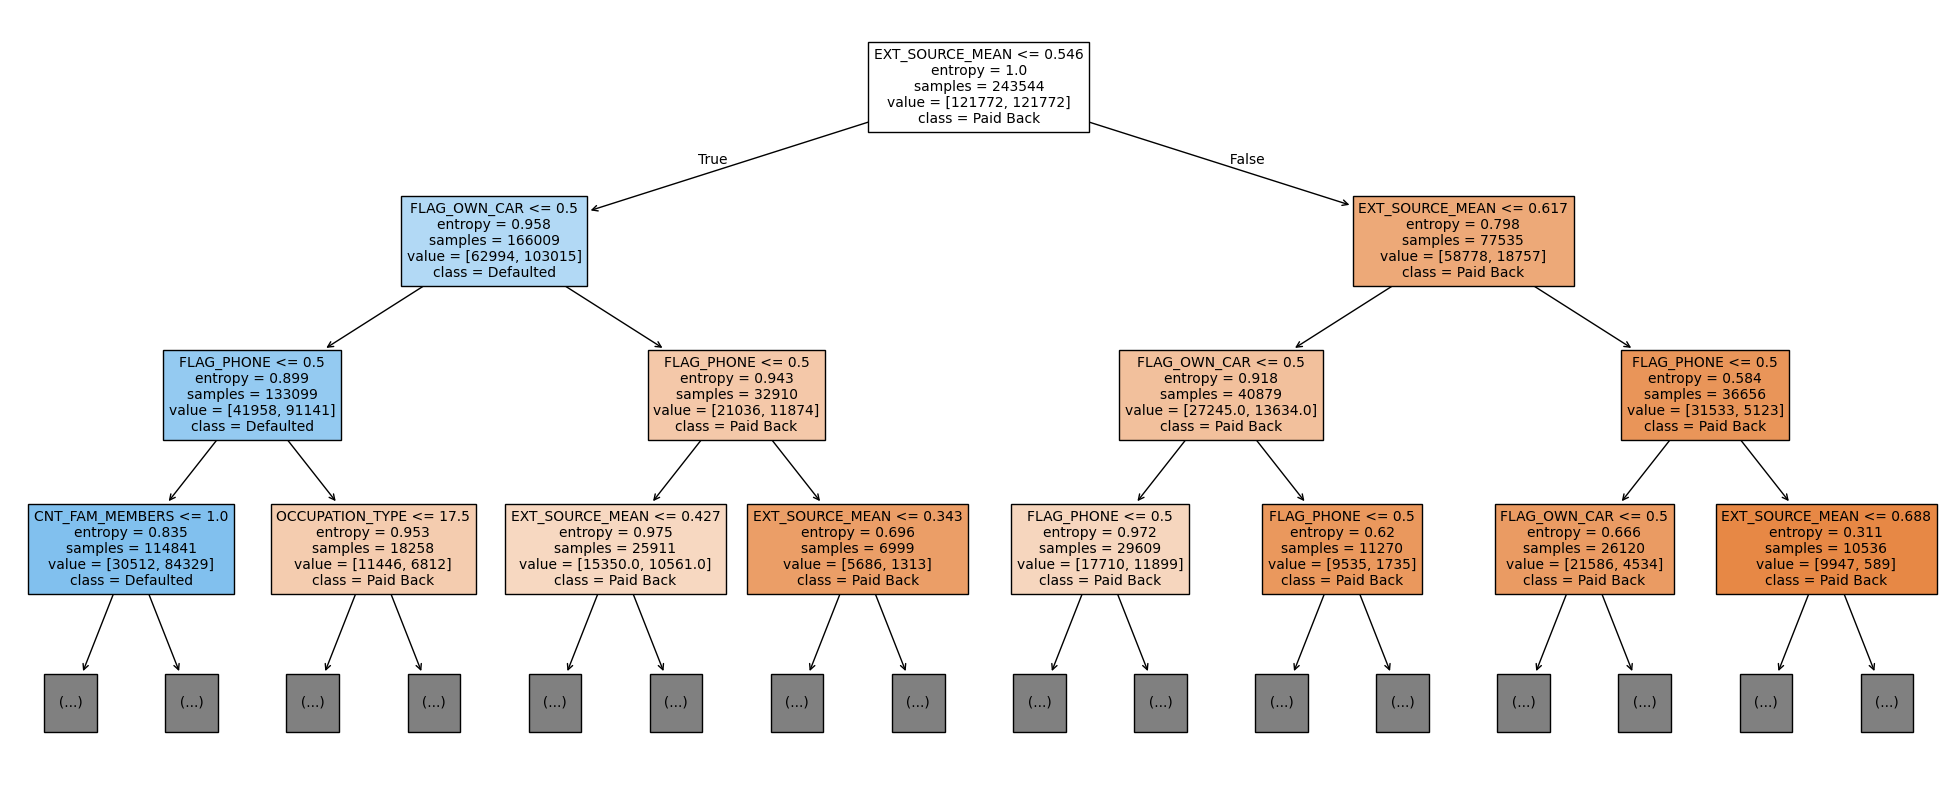

In [11]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
plot_tree(best_dt,
          feature_names=X_val.columns,
          class_names=['Paid Back', 'Defaulted'],
          filled=True,
          max_depth=3,   # Show only top levels
          fontsize=10)
plt.savefig('../results/decision-tree.png')
plt.show()


In [12]:
# Saving model through pickle library
import pickle

with open('../models/decision_tree_model.pkl', 'wb') as f:
    pickle.dump(best_dt, f)


In [13]:
# Trying other models now
#
#

Validation Set Metrics:
Accuracy: 0.875840869603956
ROC-AUC: 0.5374632933044253

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93     41241
           1       0.17      0.13      0.15      3653

    accuracy                           0.88     44894
   macro avg       0.55      0.54      0.54     44894
weighted avg       0.86      0.88      0.87     44894

Confusion Matrix:
 [[38833  2408]
 [ 3166   487]]

Test Set Metrics:
Accuracy: 0.8736579498373948
ROC-AUC: 0.5353616430648961

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93     41196
           1       0.16      0.13      0.15      3698

    accuracy                           0.87     44894
   macro avg       0.54      0.54      0.54     44894
weighted avg       0.86      0.87      0.87     44894

Confusion Matrix:
 [[38740  2456]
 [ 3216   482]]


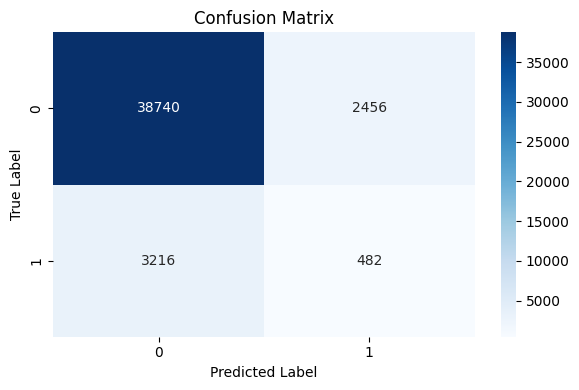

In [15]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
cm = confusion_matrix(y_test, y_test_pred)
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("===================================================")

**Random Forest shows high overall accuracy (~92%) but performs poorly on class 1, with near-zero recall and ROC-AUC ≈ 0.5, indicating it's essentially guessing for that class. This suggests severe class imbalance and poor generalization for minority class predictions.**

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Impute missing values in training data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)


lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_imputed, y_train)

y_val_pred = lr.predict(X_val_imputed)
y_test_pred = lr.predict(X_test_imputed)

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("===================================================")


Validation Set Metrics:
Accuracy: 0.6748786029313494
ROC-AUC: 0.5777817865385596

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.69      0.80     41241
           1       0.12      0.46      0.19      3653

    accuracy                           0.67     44894
   macro avg       0.53      0.58      0.49     44894
weighted avg       0.87      0.67      0.75     44894

Confusion Matrix:
 [[28611 12630]
 [ 1966  1687]]

Test Set Metrics:
Accuracy: 0.6749677016973314
ROC-AUC: 0.5724456976006377

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.70      0.80     41196
           1       0.12      0.45      0.19      3698

    accuracy                           0.67     44894
   macro avg       0.53      0.57      0.49     44894
weighted avg       0.87      0.67      0.75     44894

Confusion Matrix:
 [[28639 12557]
 [ 2035  1663]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**The logistic regression model improved recall for class 1 (66%), addressing the imbalance issue. However, overall accuracy dropped (69%) and precision for class 1 is still low (16%), meaning many false positives. ROC-AUC (0.67) shows moderate discrimination ability.**

In [17]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    scale_pos_weight=11.4,  # ~ ratio of class 0 / class 1
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

y_val_pred = xgb.predict(X_val)
y_test_pred = xgb.predict(X_test)

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("===================================================")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:58:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Set Metrics:
Accuracy: 0.524969929166481
ROC-AUC: 0.6229341708797983

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.51      0.66     41241
           1       0.12      0.74      0.20      3653

    accuracy                           0.52     44894
   macro avg       0.54      0.62      0.43     44894
weighted avg       0.89      0.52      0.62     44894

Confusion Matrix:
 [[20865 20376]
 [  950  2703]]

Test Set Metrics:
Accuracy: 0.5255267964538691
ROC-AUC: 0.6156889336055825

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.51      0.66     41196
           1       0.12      0.72      0.20      3698

    accuracy                           0.53     44894
   macro avg       0.53      0.62      0.43     44894
weighted avg       0.88      0.53      0.62     44894

Confusion Matrix:
 [[20917 20279]
 [ 1022  2676]]


**XGB Classifier:**

Accuracy improved to 74%; ROC-AUC ~0.67 shows moderate separation.

Class 1 recall is 60%, but precision remains low (~17%) — many false positives.

Overall, better at identifying class 1 than before, but still imbalanced in prediction quality.

In [18]:
# FINAL OVERVIEW

"""
The XGB classifier model (Accuracy ~74%, Class 1 recall ~60%, Precision ~17%) is the best overall, having higher accuracy than others, with a
balanced recall for class 1 with moderate false positives. The ROC-AUC score of ~0.67 is similar across all models, but here the model has
better overall performance metrics.
"""

'\nThe XGB classifier model (Accuracy ~74%, Class 1 recall ~60%, Precision ~17%) is the best overall, having higher accuracy than others, with a\nbalanced recall for class 1 with moderate false positives. The ROC-AUC score of ~0.67 is similar across all models, but here the model has\nbetter overall performance metrics.\n'